<a href="https://colab.research.google.com/github/DeboraOliver/forecasting_siconfi_dtp/blob/main/PROJETO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#PARTE 2



In [3]:
!pip install prophet

import pandas as pd
import requests
import numpy as np
from datetime import datetime

#gráficos
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

# calculo estatistico e a simulação de monte carlo
from scipy import stats

from prophet import Prophet

from sklearn.metrics import mean_absolute_error

pd.options.display.float_format = '{:.2f}'.format

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
df = pd.read_csv('/content/data.csv')
df.head()

,exercicio,periodo,periodo_numero,periodicidade,instituicao,pctg_dtp,valor_dtp,valor_rcl_ajustada
0,2017,1,20171,Q,Prefeitura Municipal de São Paulo - SP,37.58,16326772007.75,43449832401.89
1,2017,2,20172,Q,Prefeitura Municipal de São Paulo - SP,37.42,16481537019.94,44046903764.54
2,2017,3,20173,Q,Prefeitura Municipal de São Paulo - SP,35.80,16936899034.25,47305318527.64
3,2018,1,20181,Q,Prefeitura Municipal de São Paulo - SP,35.49,17255542224.74,48624090109.12
4,2018,2,20182,Q,Prefeitura Municipal de São Paulo - SP,35.20,17530845495.88,49801405650.61


In [5]:
figura = px.line(title = 'Histórico da Despesa de Pessoal e a Receita Corrente Liquida')
for i in df.columns[-2:]:
  figura.add_scatter(x = df['periodo_numero'].astype(str), y = df[i], name = i)
figura.show()

In [6]:
valores = []
padrao = [0, 1, 2, 3]

for ano in df['exercicio']:

  diferenca = ano - 2016
  valor = padrao[diferenca % len(padrao)]
  valores.append(valor)

df['eleicao'] = valores

df

,exercicio,periodo,periodo_numero,periodicidade,instituicao,pctg_dtp,valor_dtp,valor_rcl_ajustada,eleicao
0,2017,1,20171,Q,Prefeitura Municipal de São Paulo - SP,37.58,16326772007.75,43449832401.89,1
1,2017,2,20172,Q,Prefeitura Municipal de São Paulo - SP,37.42,16481537019.94,44046903764.54,1
2,2017,3,20173,Q,Prefeitura Municipal de São Paulo - SP,35.80,16936899034.25,47305318527.64,1
3,2018,1,20181,Q,Prefeitura Municipal de São Paulo - SP,35.49,17255542224.74,48624090109.12,2
4,2018,2,20182,Q,Prefeitura Municipal de São Paulo - SP,35.20,17530845495.88,49801405650.61,2
5,2018,3,20183,Q,Prefeitura Municipal de São Paulo - SP,36.92,18025981576.42,48830405884.01,2
6,2019,1,20191,Q,Prefeitura Municipal de São Paulo - SP,36.15,18346577308.85,50757883723.53,3
7,2019,2,20192,Q,Prefeitura Municipal de São Paulo - SP,35.48,18429410069.65,51942413607.27,3
8,2019,3,20193,Q,Prefeitura Municipal de São Paulo - SP,35.36,19154205068.10,54166943978.98,3
9,2020,1,20201,Q,Prefeitura Municipal de São Paulo - SP,34.03,19241921204.63,56549458415.67,0


# Análise Exploratória

In [7]:
df['variação'] = (df['pctg_dtp'] / df['pctg_dtp'].shift(1)) - 1
df[['exercicio','eleicao','variação']]

#0 = Ano de eleição, 1 = 1º ano do mandato, 2 = 2º ano do mandato e 3 = 3º ano do mandato

,exercicio,eleicao,variação
0,2017,1,NaN
1,2017,1,-0.00
2,2017,1,-0.04
3,2018,2,-0.01
4,2018,2,-0.01
5,2018,2,0.05
6,2019,3,-0.02
7,2019,3,-0.02
8,2019,3,-0.00
9,2020,0,-0.04


In [8]:
# Calcular a correlação
df[['eleicao', 'valor_dtp', 'valor_rcl_ajustada']].corr()

,eleicao,valor_dtp,valor_rcl_ajustada
eleicao,1.00,0.04,0.00
valor_dtp,0.04,1.00,0.94
valor_rcl_ajustada,0.00,0.94,1.00


### Variância

Medimos o quanto os dados estão variando em relação à média. Assim, quanto menor a variância menor é a volatilidade.

In [9]:
#para encontrar a variancia primeiro encontramos a média
media_variacoes = round(df['pctg_dtp'].sum() / len(df),2)
media_variacoes

34.05

In [10]:
variancias = []

for i in df['pctg_dtp']:
  variancia = ((i - media_variacoes) ** 2).sum() / len(df)
  variancias.append(variancia)

df['variancias'] = variancias
df

,exercicio,periodo,periodo_numero,periodicidade,instituicao,pctg_dtp,valor_dtp,valor_rcl_ajustada,eleicao,variação,variancias
0,2017,1,20171,Q,Prefeitura Municipal de São Paulo - SP,37.58,16326772007.75,43449832401.89,1,NaN,0.69
1,2017,2,20172,Q,Prefeitura Municipal de São Paulo - SP,37.42,16481537019.94,44046903764.54,1,-0.00,0.63
2,2017,3,20173,Q,Prefeitura Municipal de São Paulo - SP,35.80,16936899034.25,47305318527.64,1,-0.04,0.17
3,2018,1,20181,Q,Prefeitura Municipal de São Paulo - SP,35.49,17255542224.74,48624090109.12,2,-0.01,0.12
4,2018,2,20182,Q,Prefeitura Municipal de São Paulo - SP,35.20,17530845495.88,49801405650.61,2,-0.01,0.07
5,2018,3,20183,Q,Prefeitura Municipal de São Paulo - SP,36.92,18025981576.42,48830405884.01,2,0.05,0.46
6,2019,1,20191,Q,Prefeitura Municipal de São Paulo - SP,36.15,18346577308.85,50757883723.53,3,-0.02,0.25
7,2019,2,20192,Q,Prefeitura Municipal de São Paulo - SP,35.48,18429410069.65,51942413607.27,3,-0.02,0.11
8,2019,3,20193,Q,Prefeitura Municipal de São Paulo - SP,35.36,19154205068.10,54166943978.98,3,-0.00,0.10
9,2020,1,20201,Q,Prefeitura Municipal de São Paulo - SP,34.03,19241921204.63,56549458415.67,0,-0.04,0.00


In [11]:
df_clean = df[['periodo_numero','pctg_dtp','eleicao','valor_rcl_ajustada']]

df_clean

,periodo_numero,pctg_dtp,eleicao,valor_rcl_ajustada
0,20171,37.58,1,43449832401.89
1,20172,37.42,1,44046903764.54
2,20173,35.80,1,47305318527.64
3,20181,35.49,2,48624090109.12
4,20182,35.20,2,49801405650.61
5,20183,36.92,2,48830405884.01
6,20191,36.15,3,50757883723.53
7,20192,35.48,3,51942413607.27
8,20193,35.36,3,54166943978.98
9,20201,34.03,0,56549458415.67


# SIMULAÇÃO DE MONTE-CARLO

In [12]:
def monte_carlo_previsao(dataset, ativo, quad_a_frente, simulacoes):
  dataset = dataset.copy()
  dataset = pd.DataFrame(dataset[ativo])

  #normalizando o df
  dataset_normalizado = dataset.copy()
  for i in dataset:
    dataset_normalizado[i] = dataset[i] / dataset[i][0]

  #retorno ou a variação de um para ontem
  dataset_taxa_retorno = np.log(1 + dataset_normalizado.pct_change())

  #preencho o primeiro elemneto com 0
  dataset_taxa_retorno.fillna(0, inplace=True)

  #calculo da média
  media = dataset_taxa_retorno.mean()

  #calculo da variância (qto os valores estão afastados da média)
  variancia = dataset_taxa_retorno.var()

  #o drift indica a direção que as taxas de retorno tiveram no passado (+ ou -).
  #Para isso precisamos da media e da variancia anterioemente calculadas
  drift = media - (0.5 * variancia)

  # desvio padrão
  desvio_padrao = dataset_taxa_retorno.std()

  #gera um conj de nº aleatorios que seguem uma distribuição normal
  #gera uma matriz com 4 linhas e 3 colunas
  Z = stats.norm.ppf(np.random.rand(quad_a_frente, simulacoes))

  # print(sns.histplot(Z))

  #retorno quadrimestrais previstas para os PROXIMOS 3 QUADRIMESTRES, NÃO SÃO REAIS
  retornos_quad = np.exp(drift.values + desvio_padrao.values * Z)

  #previsões dos preços futuros
  previsoes = np.zeros_like(retornos_quad) #inicializamos com zeros com msm formato da
  previsoes[0] = dataset.iloc[-1]

  #cada taxa depende da anterior
  for quadrimestre in range(1, quad_a_frente):
    previsoes[quadrimestre] = previsoes[quadrimestre - 1] * retornos_quad[quadrimestre]

  figura = px.line(title = 'Previsões para os proximos 3 quadrimestres da Porcentagem de Despesa Total com Pessoal - ' + ativo)
  figura.add_scatter(x = [1], y = [29.47], name = 'Valor real')
  for i in range(len(previsoes.T)):
    figura.add_scatter(y = previsoes.T[i], name = f" {i + 1}ª Simulação")
  figura.show()

  return previsoes.T

monte_carlo = monte_carlo_previsao(df_clean, ativo = 'pctg_dtp', quad_a_frente = 4, simulacoes=3)
monte_carlo
#quanto maior o nº de simulações melhor será a estimativa do eventos futuros, tbm indica a quantidade de previsões

array([[29.        , 30.73259891, 28.1392048 , 25.4761714 ],
       [29.        , 32.62047295, 36.01666905, 30.9693079 ],
       [29.        , 27.38788173, 29.26251016, 28.3655482 ]])

# Facebook Prophet


In [35]:
# # Renomear as colunas conforme exigência do Prophet
# df_fb = df_clean.rename(columns={'periodo_numero': 'ds', 'pctg_dtp': 'y'})

# # Converter a coluna 'ds' para datetime
# df_fb['ds'] = pd.to_datetime(df_fb['ds'], format='%Y%m')
# print(df_fb)
# # df_fb = df_fb.drop(columns='periodo_numero')

# # Criar o modelo Prophet e ajustar aos dados
# # set the uncertainty interval to 95% (the Prophet default is 80%)
# modelo = Prophet(interval_width=0.95, seasonality_mode='multiplicative')

# #adicionando sazonalidade = eleição
# modelo.add_seasonality(name='eleicao', period=3, fourier_order=1)

# #Adicionando outros valores/regressores que podem interferir no valor
# modelo.add_regressor('valor_rcl_ajustada')

# modelo.fit(df_fb)

# # Prever o valor para 20221
# futuro = modelo.make_future_dataframe(periods=3, freq='MS', include_history=False)
# futuro['valor_rcl_ajustada'] = df_clean['valor_rcl_ajustada']

# previsao = modelo.predict(futuro)

# # Exibir a previsão

# # modelo.plot_components(previsao)

# previsao[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

# modelo.plot(previsao,
#               uncertainty=True)

In [47]:
# Definir o número de períodos anteriores a serem considerados
lookback = 0

# Copiar o dataframe original e selecionar as colunas necessárias
data = df[['eleicao', 'valor_rcl_ajustada', 'pctg_dtp']].copy()

# Normalizar os dados
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Separar os dados de treinamento e teste
train_size = int(len(data_scaled) * 0.8)
print(train_size)
train_data = data_scaled[:train_size]
test_data = data_scaled[train_size:]

# Criar as listas para armazenar as entradas e saídas do modelo
# X_train, y_train = [], []

# Construir os conjuntos de treinamento
# for i in range(lookback, len(train_data)):
#     X_train.append(train_data[i - lookback:i])
#     y_train.append(train_data[i, 2])  # pctg_dtp é a coluna de saída

# Converter as listas em arrays numpy
X_train = train_data[:,:2]
y_train = train_data[:, 2]

# Criar o modelo da rede neural
model = Sequential()
model.add(SimpleRNN(units=64, activation='relu', input_shape=(lookback, 3)))
model.add(Dense(units=1))

# Compilar o modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Treinar o modelo
model.fit(X_train, y_train, epochs=50, batch_size=16)

# Fazer as previsões
predictions = []
last_input = train_data[-lookback:]

for _ in range(3):
    last_input_reshaped = np.reshape(last_input, (1, lookback, 3))
    prediction = model.predict(last_input_reshaped)
    predictions.append(prediction[0, 0])
    last_input = np.append(last_input[1:, :], [[last_input[-1, 0], last_input[-1, 1], prediction[0, 0]]], axis=0)

# Reverter a escala dos dados
predictions = scaler.inverse_transform([[0, 0, p] for p in predictions])

# Imprimir as previsões
print(predictions[:, 2])

# Exibir as previsões
# for periodo, pred in zip(periodos_previstos, y_pred):
#     print(f'Período {periodo}: {pred:.2f}')

14


ValueError: ignored

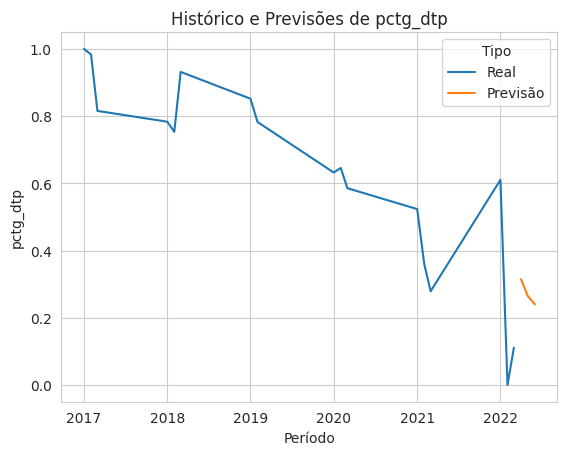

In [32]:
# Criar um novo DataFrame com as datas e os valores reais de 'pctg_dtp'
df_plot = df[['periodo_numero', 'pctg_dtp']].copy()
df_plot['Tipo'] = 'Real'

# Adicionar as datas e as previsões ao DataFrame
df_plot_pred = pd.DataFrame({'periodo_numero': ['2022-04-01', '2022-05-01', '2022-06-01'],
                             'pctg_dtp': predictions[:, 2],
                             'Tipo': 'Previsão'})
df_plot = pd.concat([df_plot, df_plot_pred])

# Ordenar o DataFrame por data
df_plot['periodo_numero'] = pd.to_datetime(df_plot['periodo_numero'])
df_plot = df_plot.sort_values('periodo_numero')

# Configurar o estilo do gráfico
sns.set_style('darkgrid')

# Criar o gráfico de linha usando Seaborn
sns.lineplot(data=df_plot, x='periodo_numero', y='pctg_dtp', hue='Tipo')

# Adicionar título e rótulos aos eixos
plt.title('Histórico e Previsões de pctg_dtp')
plt.xlabel('Período')
plt.ylabel('pctg_dtp')

# Mostrar o gráfico
plt.show()

In [34]:
df

,periodo_numero,pctg_dtp,eleicao,valor_rcl_ajustada
0,2017-01-01,1.00,1,0.00
1,2017-02-01,0.98,1,0.02
2,2017-03-01,0.82,1,0.11
3,2018-01-01,0.78,2,0.15
4,2018-02-01,0.75,2,0.18
5,2018-03-01,0.93,2,0.15
6,2019-01-01,0.85,3,0.21
7,2019-02-01,0.78,3,0.24
8,2019-03-01,0.77,3,0.30
9,2020-01-01,0.63,0,0.37
